# Tensorflow Tequila Tutorial

In this tutorial we will learn how to transform a Tequila `Objective` into a `Tensorflow Layer object`, and will optimize such an objective using Tensorflow. In particular, we are going to train a Quantum Autoencoder on the $\text{H}_{2}$, sto-3g, UCC-SD ansatz. We will consider, as input data, the angles of the UCC-SD state prep circuit, calculated at different bond lengths, and as internal weights to the model, the angles of rotation gates within the autoencoder circuit.


In [1]:
import tequila as tq
import tensorflow as tf
import tensorflow.keras.optimizers as optims
import numpy as np
from matplotlib import pyplot as plt


## 1: Generate the data.

We start by creating a number of molecule objects, each representing $\text{H}_{2}$ at different bond lengths. 
Subsequently, we extract the parameter value (there is only one) of the UCCSD ansatz, for preparing that state.

In [2]:
bond_lengths=np.linspace(.3, 1.6, 20) # our bond length, in angstrom.
amp_arrays = []
state_preps = []
for i in bond_lengths:
    # the line below initializes a tequila molecule object for H2 at a specific bond length.
    # see the quantum chemistry tutorial for more details.
    molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\n H 0.0 0.0 {}".format(str(i)), basis_set="sto-3g")
    amplitude = molecule.compute_amplitudes(method='ccsd') # get the state prep amplitudes
    amp_arrays.append(np.asarray([v for v in amplitude.make_parameter_dictionary().values()]))
    state_preps.append(molecule.make_uccsd_ansatz(trotter_steps=1,initial_amplitudes=amplitude))

Now we must create our data loader and subsequently the dataset from the data loader

In [3]:
def data_generator(amp_arrays):
    i = 0
    while i < len(amp_arrays):
        yield amp_arrays[i]
        i += 1

my_data = tf.data.Dataset.from_generator(data_generator, args=[amp_arrays], output_types=tf.float32)

## 2: Create an Ansatz `Objective`.

Our autoencoder ansatz must be a circuit that both constructs the hydrogen wavefunction, and then compresses it. Furthermore, the autoencoder cost function must be encoded into the objective. The cost function can be defined as a hamiltonian which projects all the non-latent, or 'trash' qubits, onto the all zero state.

In [4]:
encoder = tq.gates.Rx('a',0) +tq.gates.Rx('b',1) +tq.gates.CNOT(1,3) +tq.gates.CNOT(0,2)+tq.gates.CNOT(0,1)
state_prep = state_preps[0] # every member of this list is the same object; it doesn't matter which we pick.
combined = state_prep + encoder
print('combined state prep, encoder circuit:  \n', combined)

combined state prep, encoder circuit:  
 circuit: 
X(target=(0,))
X(target=(1,))
FermionicEx(target=(0, 1, 2, 3), control=(), parameter=Objective with 0 unique expectation values
variables = [(1, 0, 1, 0)]
types     = [])
FermionicEx(target=(0, 1, 2, 3), control=(), parameter=Objective with 0 unique expectation values
variables = [(1, 0, 1, 0)]
types     = [])
Rx(target=(0,), parameter=a)
Rx(target=(1,), parameter=b)
X(target=(3,), control=(1,))
X(target=(2,), control=(0,))
X(target=(1,), control=(0,))



In [5]:
# we decide that the 3rd and 4th qubits will be trash qubits. The hamiltonian below projects onto zero.
hamiltonian = tq.hamiltonian.paulis.Qm(2)*tq.hamiltonian.paulis.Qm(3)
h2_encoder = tq.ExpectationValue(U=combined,H=hamiltonian)
print('H2 autoencoder: ', h2_encoder)

H2 autoencoder:  Objective with 1 unique expectation values
variables = [(1, 0, 1, 0), a, b]
types     = not compiled


## 3: Convert the Tequila `Objective` into a Tensorflow `Layer`.

In order for Tensoflow to interact with Tequila objectives, we need to build wrappers which allow the classes of Tensorflow and tequila to work together. For user convenience, this can be done with the class `TFLayer`. 
This class takes an `Objective`, a dict of compilation args (optional), and a list of `Variable`s of the objective which should be treated as input (the data loaded into `my_data`), and will treat all the remaining variables as internal weights of the quantum neural network layer that the objective constitutes. If not specified in the compile_args dictionary, random values (between 0 and $2 \pi$) will be used for the weights.

In [6]:
input_variable=h2_encoder.extract_variables()[0]
inits={'a':1.5, 'b':1.5}
compile_args={'backend':'qulacs', 'initial_values':inits} # dict. allowed keys: backend, samples, noise, device, initial_values

In [7]:
my_tf_encoder = tq.ml.interface_tf.TFLayer(h2_encoder,compile_args,input_vars=[input_variable])
print(my_tf_encoder)

Tequila TFLayer. Represents: 
VectorObjective with 1 unique expectation values
variables = [(1, 0, 1, 0), a, b]
types     = not compiled 
Current Weights: [a, b]


## 4: Optimize using Tensorflow and plot the results.

Once converted to a Tensorflow layer, Tequila `Objective`'s can be optimized with the inbuilt tools of Tensorflow. Do note that `TFLayer` objects cannot be optimized with the tequila optimizers.

In [8]:
optim = optims.Adam(lr=0.01)

var_list_fn = lambda: my_tf_encoder.get_params_variable()  # We just want to train the parameters

loss_fn = lambda: tf.reduce_sum(my_tf_encoder())

loss_values = []

num_epochs = 30

In [9]:
for epoch in range(num_epochs):
    print('*** Epoch {} ***'.format(epoch + 1))
    batch = my_data.shuffle(20).take(10)
    batch_loss = []
    for point in batch:
        pred = my_tf_encoder(point)
        loss = loss_fn()
        batch_loss.append(loss)
        print(loss.numpy())

        # Get the gradients and apply them
        optim.minimize(loss_fn, var_list_fn)
    bv = np.mean([l.numpy() for l in batch_loss])
    loss_values.append(bv)
    print('Batched Average Loss: ', bv, "\n")

*** Epoch 1 ***
0.28661953875879514
0.28130241917954657
0.2760331406621527
0.27081308558648287
0.26564370891707356
0.26052634904435007
0.25546235029919073
0.25045299959169653
0.24549958476315759
0.24060327404798776
Batched Average Loss:  0.26329564508504333 

*** Epoch 2 ***
0.23576523425880314
0.23098651283706303
0.2262682104855237
0.2216113067440262
0.217016662920977
0.21248518952572568
0.2080176235025597
0.20361474878530036
0.19927717870176262
0.19500546718427048
Batched Average Loss:  0.2150048134946012 

*** Epoch 3 ***
0.1908001609162413
0.18666164369491722
0.18259034496963128
0.17858653523365378
0.17465043141595218
0.1707821492622906
0.16698185110090685
0.16324950427720847
0.15958507816839568
0.15598845013005283
Batched Average Loss:  0.172987614916925 

*** Epoch 4 ***
0.15245945515901937
0.14899784227520327
0.145603322983753
0.14227557249498216
0.1390141879840553
0.13581869285013062
0.13268858272546924
0.1296233266893675
0.12662232786985483
0.12368492756903729
Batched Average 

In [10]:
print("Final parameter values: ")
print(my_tf_encoder.get_params_values())

Final parameter values: 
OrderedDict([('a', 2.723287343978882), ('b', 2.723287343978882)])


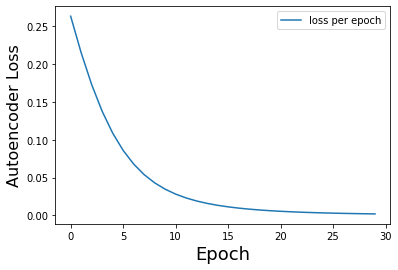

In [11]:
plt.plot(loss_values, label='loss per epoch')
plt.legend()
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Autoencoder Loss', fontsize=16)
plt.show()